<a href="https://colab.research.google.com/github/kridtapon/Momentum-RSI-Trading-Strategy/blob/main/Momentum_%2B_RSI_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.8 MB/s eta 0:00:00
  Created wheel for vectorbt: filename=vectorbt-0.26.2-py3-none-any.whl size=527326 sha256=445b655d000a9012e6ced7902d8210c912df2e231c9b52599f07937d1f331be4
  Stored in directory: /root/.cache/pip/wheels/35/a3/d2/ae1a8cbf659fffc7d1890123df1a7fa2e7f6df587c1dca71cd
Successfully built vectorbt
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      

In [7]:
import pandas as pd
import vectorbt as vbt
import yfinance as yf

def calculate_rsi(series, period=14):
    """Calculate the Relative Strength Index (RSI) manually."""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_momentum(series, period=10):
    """Calculate Momentum as the rate of change of the price over a period."""
    return series.diff(period)

def main():
    # Load historical data
    df = yf.download('AAPL', start='2014-01-01', end='2024-01-01')
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df.ffill(inplace=True)

    # Calculate Momentum (10-day)
    df['Momentum'] = calculate_momentum(df['Close'], period=100)

    # Calculate 2-day RSI
    df['RSI_2'] = calculate_rsi(df['Close'], period=14)

    # Define Entry Conditions
    df['Long_Entry'] = (df['Momentum'] > 0) & (df['RSI_2'] < 90)

    # Define Exit Conditions
    df['Long_Exit'] = df['Close'] > df['Close'].shift(5)  # Close is higher than 5 days ago

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df['Close'],
        entries=df['Long_Entry'],
        exits=df['Long_Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Display performance metrics
    print(portfolio.stats())

    # Plot equity curve
    portfolio.plot().show()

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2014-01-02 00:00:00
End                           2023-12-29 00:00:00
Period                                       2516
Start Value                              100000.0
End Value                           471860.212109
Total Return [%]                       371.860212
Benchmark Return [%]                   874.606343
Max Gross Exposure [%]                      100.0
Total Fees Paid                      12322.137356
Max Drawdown [%]                         32.31525
Max Drawdown Duration                       431.0
Total Trades                                   24
Total Closed Trades                            23
Total Open Trades                               1
Open Trade PnL                       -3096.899323
Win Rate [%]                            69.565217
Best Trade [%]                          85.562056
Worst Trade [%]                        -21.920684
Avg Winning Trade [%]                   15.074972
Avg Losing Trade [%]                    -6.717932


In [12]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=31c1f86682e2f068a5ae708b49e9dbcc11000736bdd9498cf0244558ace5e8a2
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [20]:
import pandas as pd
import numpy as np
import ta
import vectorbt as vbt

# Load and preprocess the data
def load_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.ffill(inplace=True)
    return df

# Define the backtesting function
def backtest(df, x_day, y_day):
    # Calculate momentum (X-day) and RSI (Y-day)
    df['Momentum'] = df['Close'] - df['Close'].shift(x_day)
    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=y_day).rsi()

    # Define entry signal
    df['Entry'] = (
        (df['Momentum'] > 0) &  # X-day momentum crosses over 0
        (df['RSI'] < 90)   # Y-day RSI is less than 90
    )

    # Define exit signal
    df['Exit'] = df['Close'] > df['Close'].shift(5)  # Close is higher than 5 days ago

    # Convert signals to boolean arrays
    entries = df['Entry'].to_numpy()
    exits = df['Exit'].to_numpy()

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df['Close'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001
    )

    return portfolio

# Optimize parameters
def optimize(df):
    best_params = None
    best_metric = -np.inf

    x_day_range = range(1, 31)  # Test momentum for 1-30 days
    y_day_range = range(1, 31)  # Test RSI for 1-30 days

    for x_day in x_day_range:
        for y_day in y_day_range:
                portfolio = backtest(df, x_day, y_day)
                total_return = portfolio.total_return()

                if total_return > best_metric:
                    best_metric = total_return
                    best_params = (x_day, y_day)

    return best_params, best_metric

# Main function
def main():
    # Load historical data
    filepath = 'XAGUSD_Candlestick_1_D_BID_01.01.2004-01.01.2024.csv'
    df = load_data(filepath)

    # Optimize parameters
    best_params, best_metric = optimize(df)
    print(f"Best Parameters: {best_params}")
    print(f"Best Metric (Total Return): {best_metric}")

    # Backtest with the best parameters
    x_day, y_day = best_params
    portfolio = backtest(df, x_day, y_day)

    # Display performance metrics
    print(portfolio.stats())

    # Plot equity curve
    portfolio.plot().show()

if __name__ == "__main__":
    main()


<ipython-input-20-d3673c86b991>:10: UserWarning:

Parsing dates in %d.%m.%Y %H:%M:%S.%f GMT%z format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



Best Parameters: (15, 14)
Best Metric (Total Return): 4.752847060440006


/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2003-12-31 05:00:00+07:00
End                           2024-01-01 05:00:00+07:00
Period                                             7307
Start Value                                    100000.0
End Value                                 575284.706044
Total Return [%]                             475.284706
Benchmark Return [%]                         300.944351
Max Gross Exposure [%]                            100.0
Total Fees Paid                           196290.089658
Max Drawdown [%]                              51.225412
Max Drawdown Duration                            1483.0
Total Trades                                        205
Total Closed Trades                                 204
Total Open Trades                                     1
Open Trade PnL                            -11014.200252
Win Rate [%]                                  45.588235
Best Trade [%]                                54.689642
Worst Trade [%]                              -17

In [22]:
filepath = 'XAGUSD_Candlestick_1_D_BID_01.01.2004-01.01.2024.csv'
df = load_data(filepath)

<ipython-input-20-d3673c86b991>:10: UserWarning:

Parsing dates in %d.%m.%Y %H:%M:%S.%f GMT%z format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [23]:
best_params, best_metric = optimize(df)
print(f"Best Parameters: {best_params}")
print(f"Best Metric (Total Return): {best_metric}")

Best Parameters: (15, 14)
Best Metric (Total Return): 4.752847060440006


In [39]:
import pandas as pd
import numpy as np
import ta
import vectorbt as vbt

# Load and preprocess the data
def load_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.ffill(inplace=True)
    return df

# Define the backtesting function
def backtest(df, x_day, y_day):
    # Calculate momentum (X-day) and RSI (Y-day)
    df['Momentum'] = df['Close'] - df['Close'].shift(x_day)
    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=y_day).rsi()

    # Define entry signal
    df['Entry'] = (
        (df['Momentum'] > 0) &  # X-day momentum crosses over 0
        (df['RSI'] < 90)   # Y-day RSI is less than 90
    )

    # Define exit signal
    df['Exit'] = df['Close'] > df['Close'].shift(5)  # Close is higher than 5 days ago

    # Convert signals to boolean arrays
    entries = df['Entry'].to_numpy()
    exits = df['Exit'].to_numpy()

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df['Close'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001
    )

    return portfolio

# Main function
def main():
    # Load historical data
    filepath = 'XAGUSD_Candlestick_1_D_BID_01.01.2004-01.01.2024.csv'
    df = load_data(filepath)

    # Set parameters for backtesting
    x_day = 10  # Example X-day momentum window
    y_day = 14  # Example Y-day RSI window

    # Backtest with the given parameters
    portfolio = backtest(df, x_day, y_day)

    # Display performance metrics
    print(portfolio.stats())

    # Plot equity curve
    portfolio.plot().show()

if __name__ == "__main__":
    main()


<ipython-input-39-1def3dabf135>:10: UserWarning:

Parsing dates in %d.%m.%Y %H:%M:%S.%f GMT%z format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2003-12-31 05:00:00+07:00
End                           2024-01-01 05:00:00+07:00
Period                                             7307
Start Value                                    100000.0
End Value                                 192663.380774
Total Return [%]                              92.663381
Benchmark Return [%]                         300.944351
Max Gross Exposure [%]                            100.0
Total Fees Paid                           120846.629055
Max Drawdown [%]                              68.964286
Max Drawdown Duration                            4325.0
Total Trades                                        293
Total Closed Trades                                 292
Total Open Trades                                     1
Open Trade PnL                             -2301.620795
Win Rate [%]                                  47.945205
Best Trade [%]                                  43.9732
Worst Trade [%]                              -24

<ipython-input-54-cf2dfd296eb2>:13: UserWarning:

Parsing dates in %d.%m.%Y %H:%M:%S.%f GMT%z format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2003-12-31 05:00:00+07:00
End                           2024-01-01 05:00:00+07:00
Period                                             7307
Start Value                                    100000.0
End Value                                 575284.706044
Total Return [%]                             475.284706
Benchmark Return [%]                         300.944351
Max Gross Exposure [%]                            100.0
Total Fees Paid                           196290.089658
Max Drawdown [%]                              51.225412
Max Drawdown Duration                            1483.0
Total Trades                                        205
Total Closed Trades                                 204
Total Open Trades                                     1
Open Trade PnL                            -11014.200252
Win Rate [%]                                  45.588235
Best Trade [%]                                54.689642
Worst Trade [%]                              -17

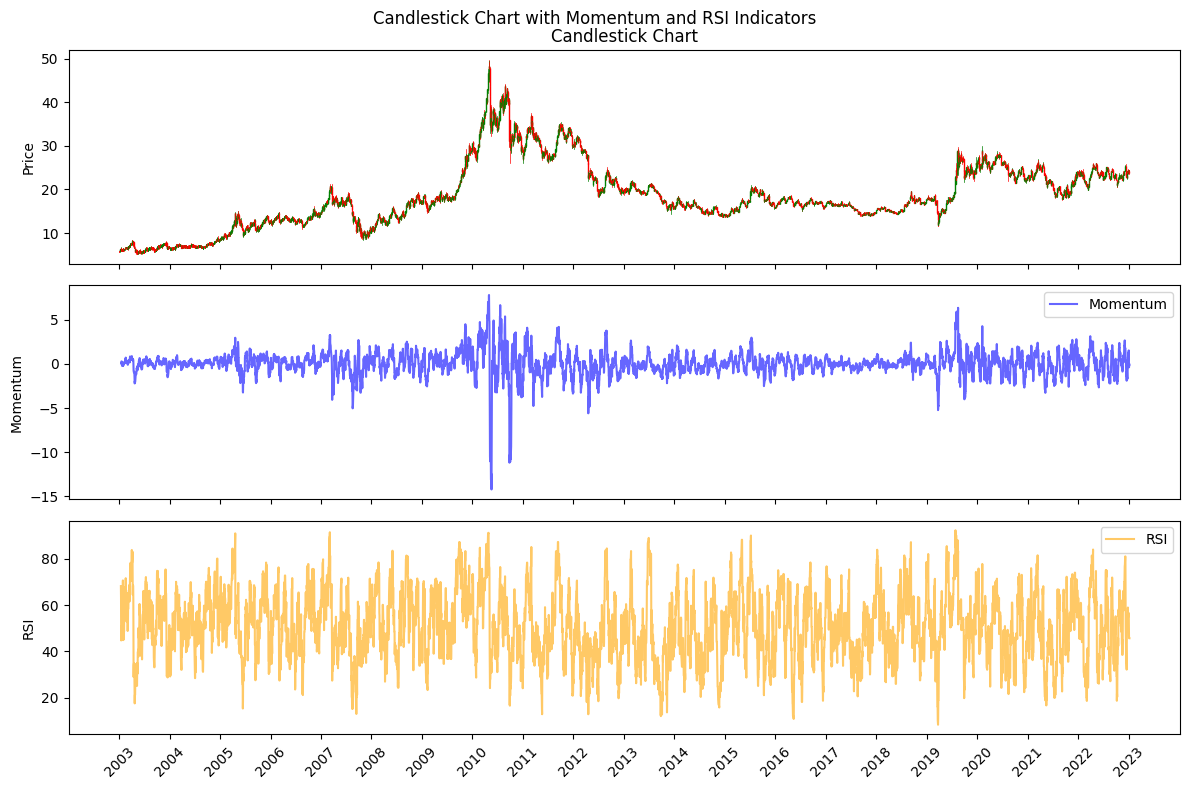

In [54]:
import pandas as pd
import numpy as np
import ta
import vectorbt as vbt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

# Load and preprocess the data
def load_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.ffill(inplace=True)
    return df

# Define the backtesting function
def backtest(df, x_day, y_day):
    # Calculate momentum (X-day) and RSI (Y-day)
    df['Momentum'] = df['Close'] - df['Close'].shift(x_day)
    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=y_day).rsi()

    # Define entry signal
    df['Entry'] = (
        (df['Momentum'] > 0) &  # X-day momentum crosses over 0
        (df['RSI'] < 90)   # Y-day RSI is less than 90
    )

    # Define exit signal
    df['Exit'] = df['Close'] > df['Close'].shift(5)  # Close is higher than 5 days ago

    # Convert signals to boolean arrays
    entries = df['Entry'].to_numpy()
    exits = df['Exit'].to_numpy()

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df['Close'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001
    )

    return portfolio, df

# Function to plot candlestick chart with indicators using matplotlib
def plot_candlestick_with_indicators(df):
    # Prepare the data for candlestick plotting
    ohlc_data = df[['Open', 'High', 'Low', 'Close']].reset_index()
    ohlc_data['Date'] = mdates.date2num(df.index)

    # Create a figure and axes for the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # Plot the candlestick chart in the first subplot
    candlestick_ohlc(ax1, ohlc_data.values, width=0.6, colorup='green', colordown='red')
    ax1.set_ylabel('Price')
    ax1.set_title('Candlestick Chart')

    # Plot Momentum in the second subplot
    ax2.plot(df.index, df['Momentum'], color='blue', label='Momentum', alpha=0.6)
    ax2.set_ylabel('Momentum')
    ax2.legend(loc='best')

    # Plot RSI in the third subplot
    ax3.plot(df.index, df['RSI'], color='orange', label='RSI', alpha=0.6)
    ax3.set_ylabel('RSI')
    ax3.legend(loc='best')

    # Set x-axis to only display years, not full date
    ax1.set_xticks(df.index[::365])  # Show ticks every year (approx. every 365 days)
    ax1.set_xticklabels(df.index.year[::365])  # Label with only the year

    # Add title for the entire figure
    plt.suptitle('Candlestick Chart with Momentum and RSI Indicators')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Adjust the top to fit the title
    plt.show()

# Main function
def main():
    # Load historical data
    filepath = 'XAGUSD_Candlestick_1_D_BID_01.01.2004-01.01.2024.csv'
    df = load_data(filepath)

    # Set parameters for backtesting
    x_day = 15  # Example X-day momentum window
    y_day = 14  # Example Y-day RSI window

    # Backtest with the given parameters
    portfolio, df = backtest(df, x_day, y_day)

    # Display performance metrics
    print(portfolio.stats())

    # Plot equity curve
    portfolio.plot().show()

    # Plot candlestick chart with indicators
    plot_candlestick_with_indicators(df)

if __name__ == "__main__":
    main()
